In [1]:
import numpy as np
import matplotlib.pyplot as plt
import colour  # pip install colour-science
import os
from tkinter import Tk, filedialog

Enter the packign density (from 0 to 100, the step size):  1


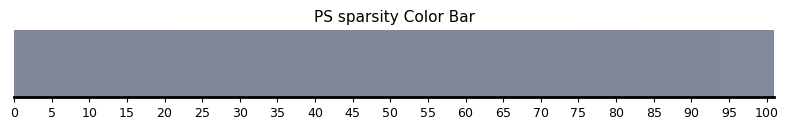

In [7]:
# --- Step 1: Ask for folder and max thickness ---
Tk().withdraw()  # Hide the root window
folder = filedialog.askdirectory(title="Select Folder with Reflectance Files")
packing = int(input("Enter the packign density (from 0 to 100, the step size): "))

# --- Step 2: Setup color science definitions ---
spectral_shape = colour.SpectralShape(360, 830, 1)
cmfs = colour.MSDS_CMFS['CIE 1931 2 Degree Standard Observer'].copy().align(spectral_shape)
illuminant = colour.SDS_ILLUMINANTS['D65'].copy().align(spectral_shape)

# --- Step 3: Read reflectance files and predict sRGB ---
colors = []
thickness_list = []

for t in np.arange(0, 100 + packing, packing):
    filename = f"PS_1500nm{t}.txt"
    filepath = os.path.join(folder, filename)
    
    if not os.path.exists(filepath):
        continue

    wavelengths, reflectance = np.loadtxt(filepath, delimiter=",", unpack=True)
    sd = colour.SpectralDistribution(dict(zip(wavelengths, reflectance)), name=f"{t}nm").align(spectral_shape)
    xyz = colour.sd_to_XYZ(sd, cmfs, illuminant)
    rgb = np.clip(colour.XYZ_to_sRGB(xyz / 100), 0, 1)

    colors.append(rgb)
    thickness_list.append(t)

# --- Step 4: Plot the color bar ---
fig, ax = plt.subplots(figsize=(8, 1.2))
for i in range(len(colors)):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=colors[i]))

ax.set_xlim(0, len(colors))
ax.set_ylim(0, 1)

# --- Step 5: Custom ticks at intervals of 50 nm ---
tick_packing = np.arange(0, packing + 100, 5)
tick_positions = []
for tick in tick_packing:
    if tick in thickness_list:
        tick_positions.append(thickness_list.index(tick))  # center of color block

ax.set_xticks(tick_positions)
ax.set_xticklabels([f"{t}" for t in tick_packing], fontsize=9)

# Clean look
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)

plt.tight_layout()
#plt.title("MoO₃ Thickness Color Bar", fontsize=11)
plt.title("PS sparsity Color Bar", fontsize=11)
plt.savefig("PS_colorbar_packing.png", dpi=300)
plt.show()